# ATLAS Experimentation
In short, we are now looking to develop ATLAS for trial in XWB25.

This entails a few things:
1. Re-training our ASR model to achieve
- At least 30% WER on radio communications regardless of location of AO
- At least 1.0 or below RTF (Real Time Factor)
2. Field Deployability (standalone laptop without internet)


Currently, for this notebook, we will be working with official public data. This data comes from the publicly available radio frequencies used in XWB 25, and we will start with understanding the language, phrasologies, and R/T used. 

After understanding the lexicon usage and pattenrs, we will proceed to generate audio data (in Singlish accent if possible). This will allow us to generate data to train the ASR model.
>https://huggingface.co/spaces/hexgrad/Kokoro-TTS
> Onyx sounds good, Liam sounds enthu, Puck not bad
> 💡 Customize pronunciation with Markdown link syntax and /slashes/ like [Kokoro](/kˈOkəɹO/)

> 💬 To adjust intonation, try punctuation ;:,.!?—…"()“” or stress ˈ and ˌ

> ⬇️ Lower stress [1 level](-1) or [2 levels](-2)

> ⬆️ Raise stress 1 level [or](+2) 2 levels (only works on less stressed, usually short words)

After generating the audio and collecting their respective source transcripts, we will proceed to train the ASR model.

On top of this, we will also add prompting to the ASR model, to help it adapt to ad-hoc changes to phrases i.e., when we move between AOs and we lack sufficient time to re-train the model. 

For Whisper, we will need to consider the architectural differences between HF Whisper and OpenAI whisper, as their layers are named differently (see `jlvdoorn`'s code where he converted HF to OpenAI-compatible API to test prompting). 

This will take time, and may not give the best results, so prompting will come when we have the base model re-trained. In short, prompting is a time-consuming gamble for performance, so it should have lower priority.

Additionally, different backends (i.e., faster-whisper, whisper c++ etc) used for our chosen model may affect:
1. Whether the backend supports prompting
2. Any significant impact on performance if prompting


In [6]:
import random
import re
import gzip
import collections
from datetime import datetime

import matplotlib.pyplot as plt
import os

In [7]:

# -----------------------------------------------------------------------------
# GRID SEARCH PARAMETERS (Lists)
# -----------------------------------------------------------------------------

geo_landmarks = [
    "Mount Lion", "Glen", "Plains", "Williamson", "Canal Creek", "Camp Tilpal",
    "Pointer", "Akens Island", "Townshend Island", "Mount Hummock", "Raspberry Creek",
    "Sam Hill", "Tilpal", "The Peninsula", "Torilla", "Byfield", "Cape Clinton",
    "Cape Manifold", "Freshwater Bay"
]

generic_ao = [
    "Shoalwater Bay Training Area",
    "Shoalwater Bay Expanded Area",
    "Rocky",
    "Rockhampton",
    "Coral Approach",
    "Brisbane Centre"
]

coded_military_ao = [
    "Kapyong ROZ", "Spike ROZ", "Harp", "Kingfisher", "Ammo Point",
    "BSSZ", "ACA", "UOTF", "UOLF", "LST Control Zone De"
]

ip_waypoints = ["IP November", "IP Sierra", "IP Echo", "IP Whiskey"]
numbered_waypoints = [f"Waypoint {i}" for i in range(1, 11)]
waypoints = ip_waypoints + numbered_waypoints  # total 14 waypoints

altitudes = [
    "500ft", "1000ft", "1500ft", "2000ft", "2500ft", "3000ft", 
    "4000ft", "5000ft", "6000ft", "7000ft", "8000ft", "9000ft", "10000ft"
]

base_callsigns = [
    "Python", "Rayban", "Niro", "Kasper", "Pedal", "Ricoh", "Batman", "Robin", 
    "Hulk", "Aston", "Pistol", "Lobster", "Milo", "Vodka", "Starling", "Salmon",
    "Piston","Whiskey","Tiger","Cola","Cobra"
]
# special_callsigns = [
#     "SINGA8514", "Sierra Eyes", "SINGA3350"
# ]



# Build callsigns from base_callsigns (each with numbers appended) and then extend with specials.
callsigns = [f"{name}{num}" for name in base_callsigns for num in range(1, 5)]
# callsigns.extend(special_callsigns)

# -----------------------------------------------------------------------------
# HELPER FUNCTION TO DERIVE CALLSIGN PAIRS
# -----------------------------------------------------------------------------
def get_callsign_pair(cs):
    """
    Given a callsign, splits it into a "with number" and a "without number" version.
    If the callsign ends with digits, the version without those digits is returned;
    otherwise, both values are the same.
    """
    # Modified the regex to match both uppercase and lowercase letters.
    match = re.match(r"([A-Za-z]+)(\d+)$", cs)
    if match:
        base, number = match.groups()
        cs_with = cs      # e.g., Python1
        cs_without = base # e.g., Python
    else:
        cs_with = cs
        cs_without = cs
    return cs_with, cs_without

# Build a list of callsign pairs for all callsigns.
callsign_pairs = [get_callsign_pair(cs) for cs in callsigns]

In [8]:
import random

def turbulence_template(d, cs1_with, cs1_without, cs2_with, cs2_without, wp, geo, generic, coded, alt):
    options = [
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} moderate turbulence reported east of {geo}, avoid ridge near {wp}, maintain low-level {alt}",
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} expect chop east of {geo}, steer clear of ridge near {wp}, keep at {alt}",
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} turbulence zone near {geo}, bypass via {wp}, altitude restriction {alt}",
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} heavy turbulence eastward of {geo}, reroute away from {wp}, fly at {alt}",
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} rough air near {geo}, divert around ridge by {wp}, hold {alt}"
    ]
    return random.choice(options)

def icing_template(d, cs1_with, cs1_without, cs2_with, cs2_without, wp, geo, generic, coded, alt):
    options = [
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} icing reported above {alt} near {geo}, route via {wp} to avoid",
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} ice layer detected above {alt}, use {wp} to bypass {geo}",
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} icing hazard over {geo}, climb below {alt} or reroute via {wp}",
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} icing observed around {geo}, shift path to {wp}, stay under {alt}",
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} reports of severe icing above {alt} by {geo}, avoid zone via {wp}"
    ]
    return random.choice(options)

def visibility_template(d, cs1_with, cs1_without, cs2_with, cs2_without, wp, geo, generic, coded, alt):
    options = [
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} visibility below 1km in {coded} valley, delay ingress via {wp}, hold at {alt}",
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} dense fog in {coded}, ingress via {wp} suspended, altitude {alt}",
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} low vis in {coded} sector, reroute from {wp}, maintain {alt}",
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} visual contact lost in {coded} valley, use {wp} only when clear, altitude hold {alt}",
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} limited visibility in {coded}, delay entry via {wp}, keep at {alt}"
    ]
    return random.choice(options)

def storm_template(d, cs1_with, cs1_without, cs2_with, cs2_without, wp, geo, generic, coded, alt):
    options = [
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} storm activity near {geo} coastline, divert inland via {generic} and hold {alt}",
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} thunderstorm cells along {geo} coast, reroute using {generic}, stay at {alt}",
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} convective weather over {geo}, transition via {generic}, hold {alt}",
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} storm front offshore {geo}, alternate route via {generic}, maintain {alt}",
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} severe wx near {geo}, divert path inland along {generic}, hold altitude {alt}"
    ]
    return random.choice(options)


In [9]:
# -----------------------------------------------------------------------------
# TEMPLATE FUNCTIONS
# -----------------------------------------------------------------------------
# Each lambda now takes two callsign pairs as parameters:
# direction, cs1_with, cs1_without, cs2_with, cs2_without, wp, geo, generic, coded, alt
# The order depends on the direction:
#   - For "to": first uses the "with" version and second uses the "without" version.
#   - For "from": first uses the "without" version and second uses the "with" version.
new_templates = [
    lambda d, cs1_with, cs1_without, cs2_with, cs2_without, wp, geo, generic, coded, alt: 
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} track {wp} then continue over {geo} at {alt}",

    lambda d, cs1_with, cs1_without, cs2_with, cs2_without, wp, geo, generic, coded, alt: 
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} clear track for {geo} and maintain {alt}",

    lambda d, cs1_with, cs1_without, cs2_with, cs2_without, wp, geo, generic, coded, alt: 
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} proceed via {wp} then over {generic} at {alt}",

    lambda d, cs1_with, cs1_without, cs2_with, cs2_without, wp, geo, generic, coded, alt: 
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} operate in {coded} and surface to {alt}",

    lambda d, cs1_with, cs1_without, cs2_with, cs2_without, wp, geo, generic, coded, alt: 
        f"all aircraft {coded} active keep clear and hold {alt}",

    lambda d, cs1_with, cs1_without, cs2_with, cs2_without, wp, geo, generic, coded, alt: 
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} shift to {wp} then report over {geo} at {alt}",

    lambda d, cs1_with, cs1_without, cs2_with, cs2_without, wp, geo, generic, coded, alt: 
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} copy track {wp} then fly over {generic} at {alt}",

    lambda d, cs1_with, cs1_without, cs2_with, cs2_without, wp, geo, generic, coded, alt: 
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} continue on {generic} then switch to {wp} over {coded} at {alt}",

    lambda d, cs1_with, cs1_without, cs2_with, cs2_without, wp, geo, generic, coded, alt: 
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} update position {wp} then verify {geo} at {alt}",

    lambda d, cs1_with, cs1_without, cs2_with, cs2_without, wp, geo, generic, coded, alt: 
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} confirm clear operation in {coded} report over {wp} at {alt}",

    lambda d, cs1_with, cs1_without, cs2_with, cs2_without, wp, geo, generic, coded, alt: 
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} maintain track for {generic} then fly via {wp} over {geo} at {alt}",

    lambda d, cs1_with, cs1_without, cs2_with, cs2_without, wp, geo, generic, coded, alt: 
        f"{cs1_with if d=='to' else cs1_without} {cs2_without if d=='to' else cs2_with} you are cleared for transition to {generic} then proceed over {coded} at {alt}",

    turbulence_template,
    icing_template,
    visibility_template,
    storm_template,
    
]
#  #    ETA, unable to suppress, unknown spotted, relay information to another a/c, report BDA, 

# -----------------------------------------------------------------------------
# OTHER PARAMETERS
# -----------------------------------------------------------------------------
directions = ["to", "from"]


In [10]:

# -----------------------------------------------------------------------------
# RANDOM COMMUNICATION GENERATION
# -----------------------------------------------------------------------------
def generate_random_communication():
    """
    Generates a single communication string by selecting one random element from each parameter list.
    Ensures the callsign with number appears correctly based on communication direction.
    """
    tpl = random.choice(new_templates)
    direction = random.choice(directions)
    
    # Select two distinct callsign pairs with different bases.
    cs1 = random.choice(callsign_pairs)
    cs2 = random.choice(callsign_pairs)
    while cs2[1] == cs1[1]:
        cs2 = random.choice(callsign_pairs)

    # Ensure proper callsign structure based on direction
    if direction == "to":
        # First is aircraft (with number), second is unit (without number)
        while any(char.isdigit() for char in cs2[1]):
            cs2 = random.choice(callsign_pairs)
            while cs2[1] == cs1[1]:
                cs2 = random.choice(callsign_pairs)
    else:
        # FROM direction: first is unit (without number), second is aircraft (with number)
        while any(char.isdigit() for char in cs1[1]):
            cs1 = random.choice(callsign_pairs)
            while cs2[1] == cs1[1]:
                cs2 = random.choice(callsign_pairs)

    wp = random.choice(waypoints)
    geo = random.choice(geo_landmarks)
    generic = random.choice(generic_ao)
    coded = random.choice(coded_military_ao)
    alt = random.choice(altitudes)

    # Generate the communication using the selected parameters.
    return tpl(direction, cs1[0], cs1[1], cs2[0], cs2[1], wp, geo, generic, coded, alt)


# -----------------------------------------------------------------------------
# TOOLS TO MEASURE AND ENSURE THE UNIFORMITY OF THE DISTRIBUTION
# -----------------------------------------------------------------------------
def sample_and_measure(num_samples=100000):
    """
    Generates a number of random communications and measures the frequency distribution
    for templates and directions.
    Returns the collected counters.
    """
    template_counter = collections.Counter()
    direction_counter = collections.Counter()
    
    for _ in range(num_samples):
        # We still select callsigns randomly (with the constraint) but only measure templates and directions.
        tpl = random.choice(new_templates)
        direction = random.choice(directions)
        
        # Choose two distinct callsign pairs.
        cs1 = random.choice(callsign_pairs)
        cs2 = random.choice(callsign_pairs)
        while cs2[1] == cs1[1]:
            cs2 = random.choice(callsign_pairs)
        
        wp = random.choice(waypoints)
        geo = random.choice(geo_landmarks)
        generic = random.choice(generic_ao)
        coded = random.choice(coded_military_ao)
        alt = random.choice(altitudes)
        
        _ = tpl(direction, cs1[0], cs1[1], cs2[0], cs2[1], wp, geo, generic, coded, alt)
        
        tpl_index = new_templates.index(tpl)
        template_counter[tpl_index] += 1
        direction_counter[direction] += 1

    return template_counter, direction_counter

# -----------------------------------------------------------------------------
# SAVE SAMPLE COMMUNICATIONS TO A COMPRESSED FILE (OPTIONAL)
# -----------------------------------------------------------------------------

TOTAL_NUM_SAMPLES = 5000
SAMPLES_PER_FILE = 250
TEXT_FILE_PREPEND = 'sim_comms'
def generate_samples_to_file(total_num_samples,samples_per_file, filename="communications_random"):
    """
    Generates a specified number of random communications and writes them to a gzip file, max 5k per file
    """
    total_files = int(total_num_samples / samples_per_file)
    folder_name = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    sim_folder_path = os.path.join('.', folder_name,'initial')
    if not os.path.exists(sim_folder_path):
        os.makedirs(sim_folder_path)
    for file in range(total_files): 
        new_filename = sim_folder_path + '/'+filename +'_'+ str(file) + '.txt'
        print(new_filename)
        with open(new_filename, "w") as outfile:
            for _ in range(samples_per_file):
                comm = generate_random_communication()
                outfile.write(comm + "\n")
    print(f"{total_num_samples} random communications generated and stored in '{folder_name}'.")
    return folder_name
folder_name = generate_samples_to_file(TOTAL_NUM_SAMPLES, SAMPLES_PER_FILE, TEXT_FILE_PREPEND)

./2025-04-12_02-55-42/initial/sim_comms_0.txt
./2025-04-12_02-55-42/initial/sim_comms_1.txt
./2025-04-12_02-55-42/initial/sim_comms_2.txt
./2025-04-12_02-55-42/initial/sim_comms_3.txt
./2025-04-12_02-55-42/initial/sim_comms_4.txt
./2025-04-12_02-55-42/initial/sim_comms_5.txt
./2025-04-12_02-55-42/initial/sim_comms_6.txt
./2025-04-12_02-55-42/initial/sim_comms_7.txt
./2025-04-12_02-55-42/initial/sim_comms_8.txt
./2025-04-12_02-55-42/initial/sim_comms_9.txt
./2025-04-12_02-55-42/initial/sim_comms_10.txt
./2025-04-12_02-55-42/initial/sim_comms_11.txt
./2025-04-12_02-55-42/initial/sim_comms_12.txt
./2025-04-12_02-55-42/initial/sim_comms_13.txt
./2025-04-12_02-55-42/initial/sim_comms_14.txt
./2025-04-12_02-55-42/initial/sim_comms_15.txt
./2025-04-12_02-55-42/initial/sim_comms_16.txt
./2025-04-12_02-55-42/initial/sim_comms_17.txt
./2025-04-12_02-55-42/initial/sim_comms_18.txt
./2025-04-12_02-55-42/initial/sim_comms_19.txt
5000 random communications generated and stored in '2025-04-12_02-55-4

In [11]:
#touch text files for variance to add in later when gpt is done
VARIANCE_FOLDER_NAME = os.path.join('.', folder_name, 'variance')
def touch_variance_to_file(total_num_samples,samples_per_file, foldername, filename="variance_communications_random"):
    """
    Generates a specified number of random communications and writes them to a gzip file, max 5k per file
    """
    total_files = int(total_num_samples / samples_per_file)
    folder_name = foldername
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    

    for file in range(total_files): 
        new_filename = folder_name + '/'+filename +'_'+ str(file) +'_'+'variance' '.txt'
        print(new_filename)
        with open(new_filename, "w") as outfile:
                outfile.write('')
    print(f"{total_num_samples} files touched and stored in '{folder_name}'.")
    
touch_variance_to_file(TOTAL_NUM_SAMPLES, SAMPLES_PER_FILE,VARIANCE_FOLDER_NAME,TEXT_FILE_PREPEND)

./2025-04-12_02-55-42/variance/sim_comms_0_variance.txt
./2025-04-12_02-55-42/variance/sim_comms_1_variance.txt
./2025-04-12_02-55-42/variance/sim_comms_2_variance.txt
./2025-04-12_02-55-42/variance/sim_comms_3_variance.txt
./2025-04-12_02-55-42/variance/sim_comms_4_variance.txt
./2025-04-12_02-55-42/variance/sim_comms_5_variance.txt
./2025-04-12_02-55-42/variance/sim_comms_6_variance.txt
./2025-04-12_02-55-42/variance/sim_comms_7_variance.txt
./2025-04-12_02-55-42/variance/sim_comms_8_variance.txt
./2025-04-12_02-55-42/variance/sim_comms_9_variance.txt
./2025-04-12_02-55-42/variance/sim_comms_10_variance.txt
./2025-04-12_02-55-42/variance/sim_comms_11_variance.txt
./2025-04-12_02-55-42/variance/sim_comms_12_variance.txt
./2025-04-12_02-55-42/variance/sim_comms_13_variance.txt
./2025-04-12_02-55-42/variance/sim_comms_14_variance.txt
./2025-04-12_02-55-42/variance/sim_comms_15_variance.txt
./2025-04-12_02-55-42/variance/sim_comms_16_variance.txt
./2025-04-12_02-55-42/variance/sim_comms_

In [12]:

# -----------------------------------------------------------------------------
# DEMONSTRATE THE DISTRIBUTION MEASUREMENT
# -----------------------------------------------------------------------------
num_samples = 100000  # Adjust as needed
template_counts, direction_counts = sample_and_measure(num_samples=num_samples)

print("Template distribution (template_index: frequency):")
for tpl_index, count in sorted(template_counts.items()):
    print(f"Template {tpl_index+1}: {count} ({count/num_samples:.2%})")

print("\nDirection distribution (direction: frequency):")
for direction, count in direction_counts.items():
    print(f"Direction '{direction}': {count} ({count/num_samples:.2%})")

Template distribution (template_index: frequency):
Template 1: 6323 (6.32%)
Template 2: 6267 (6.27%)
Template 3: 6209 (6.21%)
Template 4: 6216 (6.22%)
Template 5: 6256 (6.26%)
Template 6: 6237 (6.24%)
Template 7: 6266 (6.27%)
Template 8: 6213 (6.21%)
Template 9: 6316 (6.32%)
Template 10: 6187 (6.19%)
Template 11: 6121 (6.12%)
Template 12: 6282 (6.28%)
Template 13: 6217 (6.22%)
Template 14: 6306 (6.31%)
Template 15: 6250 (6.25%)
Template 16: 6334 (6.33%)

Direction distribution (direction: frequency):
Direction 'from': 50119 (50.12%)
Direction 'to': 49881 (49.88%)


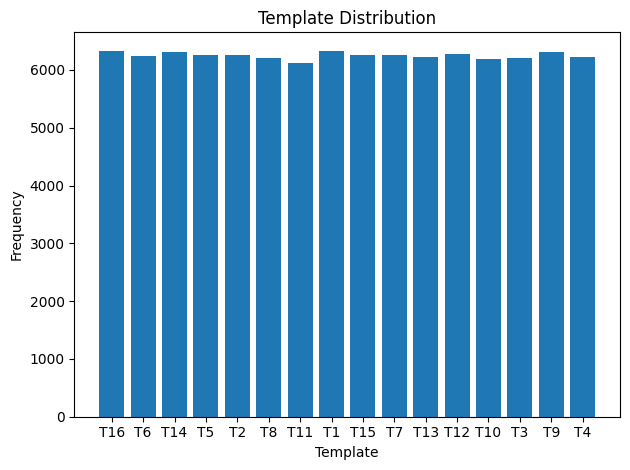

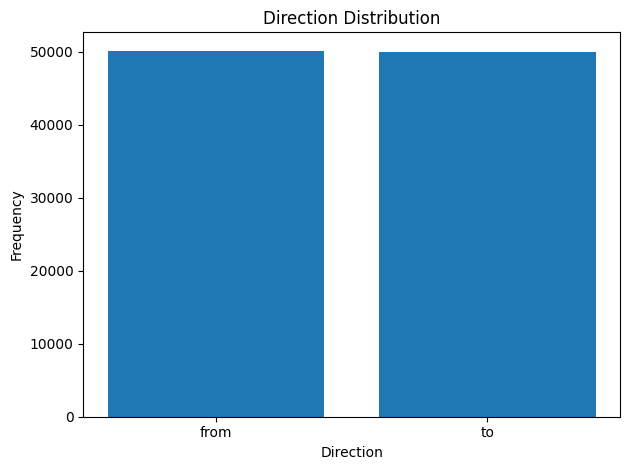

In [13]:

# -----------------------------------------------------------------------------
# PLOTTING THE DISTRIBUTION FOR VISUAL CONFIRMATION
# -----------------------------------------------------------------------------
plt.figure()
plt.bar([f"T{tpl+1}" for tpl in template_counts.keys()], template_counts.values())
plt.title("Template Distribution")
plt.xlabel("Template")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(direction_counts.keys(), direction_counts.values())
plt.title("Direction Distribution")
plt.xlabel("Direction")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# EXAMPLE USAGE:
# Generate a single random communication
# print("\nRandom example communication:")
# print(generate_random_communication())

# To generate and save 1000 random communications to a file, uncomment:
# generate_samples_to_file(1000)


# Data Augmentation

We will have to ensure that the data is not too uniform, making it harder for the model to overfit. We can consider:
1. Changing the structure of the sentences
2. Adding/removing words to disrupt the normality